In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))

In [2]:
from BEACH.lib import *

c = np.array([[0,2.5],[2,5+10]])

In [3]:
import pandas as pd
df = pd.DataFrame(c, columns=['j', 'coef'])
df.to_csv('coef_file.csv', index=False)

In [4]:
df = pd.read_csv('coef_file.csv')
df

,j,coef
0,0.0,2.5
1,2.0,15.0


In [5]:
len(c)

2

In [14]:
x,y = np.linspace(-50,50,100), np.linspace(-50,50,100)
Gen = GenBeam(1000,x,y,df['coef'].values)
z= Gen.basis_j((2,2))

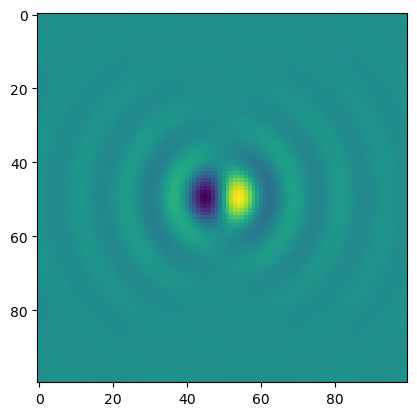

In [15]:
plt.imshow(z[1,:].reshape(100,100))

In [8]:
g = twoD_Gaussian(x,y,1,7,10,1,0,45,0)

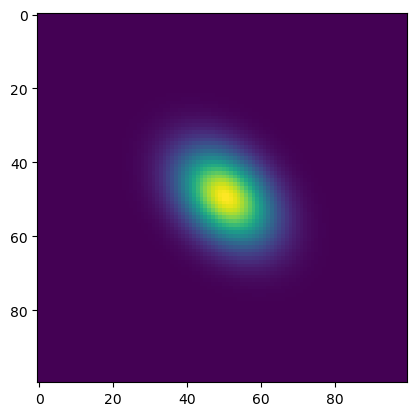

In [9]:
plt.imshow(g)